# 2021-12-23 Update Note

- Being discouraged by the low performance of transformer, and research, I will move back to "more" epoch of xresnet.

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


- I will use xresnet and their datablock, optimizer from fastai.

- NOTE: if you do not have installed [nvidia/apex](https://github.com/nvidia/apex),  change `from exp.nb_10c import *` to `from exp.nb_10b import *` in `exp.nb_11`

In [1]:
from exp.nb_12a import *

- Local data (which is divided into separate dataset) is saved to `Path('/gdrive/Shareddrives/Dion-Account/2122WS/8-dl4slp/coding-project/data/v1/ser'`


In [2]:
root_path = Path('/gdrive/Shareddrives/Dion-Account/2122WS/8-dl4slp/coding-project/ser/data/v1'); root_path.ls()

[PosixPath('/gdrive/Shareddrives/Dion-Account/2122WS/8-dl4slp/coding-project/ser/data/v1/train'),
 PosixPath('/gdrive/Shareddrives/Dion-Account/2122WS/8-dl4slp/coding-project/ser/data/v1/dev'),
 PosixPath('/gdrive/Shareddrives/Dion-Account/2122WS/8-dl4slp/coding-project/ser/data/v1/ser.tar-v1.gz')]

features-entry contains a list of a list with 26 items.
- length of inner list: 26 (float numbers - represent one preprocessed speech frame (logMel))

- length of outer list: number of frames per data-point, e.g. 10 or 15, ...

In [3]:
train_path = root_path/'train'

audios = get_files(train_path)
class AudioList(ItemList):
    @classmethod
    def from_files(cls, path, extensions = None, recurse=True, include=None, **kwargs):
        return cls(get_files(path, extensions, recurse=recurse, include=include), path, **kwargs)
    
    def get(self, fn):
        return torch.load(fn)
        
# al=AudioList.from_files(train_path); al

class Reshape():
    _order=12
    def __call__(self, item):
        w, h = item.shape
        return item.view(h, w)

# Mutants of input tensor
class PadorTrim():
    
    _order = 20
    def __init__(self, max_len):
        self.max_len = max_len
    def __call__(self, ad):
        # h - logmel, here 27, w - frames / various
        h, w = ad.shape
        pad_size = self.max_len - w
        if pad_size >0: return torch.cat((ad, torch.zeros(h, pad_size).to(ad.device)), dim=1)
        else: return ad[:, :self.max_len]
class DummyChannel():
    _order = 30
    def __call__(self, item):
        return item.unsqueeze(0)        

In [4]:
class SpecAugment():
    _order=99
    def __init__(self, max_mask_pct=0.2, freq_masks=1, time_masks=1, replace_with_zero=False):
        self.max_mask_pct, self.freq_masks, self.time_masks, self.replace_with_zero = \
        max_mask_pct, freq_masks, time_masks, replace_with_zero
        if not 0 <= self.max_mask_pct <= 1.0: 
            raise ValueError( f"max_mask_pct must be between 0.0 and 1.0, but it's {self.max_mask_pct}")

    def __call__(self, spec):
        _, n_mels, n_steps = spec.shape
        F = math.ceil(n_mels * self.max_mask_pct) # rounding up in case of small %
        T = math.ceil(n_steps * self.max_mask_pct)
        fill = 0 if self.replace_with_zero else spec.mean()
        for i in range(0, self.freq_masks):
            f = random.randint(0, F)
            f0 = random.randint(0, n_mels-f)
            spec[0][f0:f0+f] = fill
        for i in range(0, self.time_masks):
            t = random.randint(0, T)
            t0 = random.randint(0, n_steps-t)
            spec[0][:,t0:t0+t] = fill
        return spec

In [5]:
masker = SpecAugment(freq_masks=1, time_masks=2, max_mask_pct=0.1)
tfms = [Reshape(), PadorTrim(250), DummyChannel(), masker]
al=AudioList.from_files(train_path, tfms=tfms)

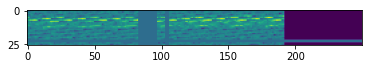

In [6]:
plt.imshow(al[3].squeeze(0))

In [6]:
def re_labeler(fn, pat, subcl='act'):
    assert subcl in ['act', 'val', 'all']
    if subcl=='all': return ''.join(re.findall(pat, str(fn)))
    else:
        return re.findall(pat, str(fn))[0] if pat == 'act' else re.findall(pat, str(fn))[1]

label_pat = r'_(\d+)'
emotion_labeler = partial(re_labeler, pat=label_pat, subcl='val')

In [7]:
sd = SplitData.split_by_func(al, partial(random_splitter, p_valid=0.01))
ll = label_by_func(sd, emotion_labeler, proc_y=CategoryProcessor())

In [8]:
bs=64
c_in = ll.train[0][0].shape[0]
c_out = len(uniqueify(ll.train.y))
data = ll.to_databunch(bs,c_in=c_in,c_out=c_out)

In [9]:
ll.train[0][0].shape

torch.Size([1, 26, 250])

In [10]:
c_in, c_out

(1, 2)

In [11]:
opt_func = adam_opt(mom=0.9, mom_sqr=0.99, eps=1e-6, wd=1e-1, )
loss_func = nn.CrossEntropyLoss()
lr = 1e-2
pct_start = 0.5
phases = create_phases(pct_start)
sched_lr  = combine_scheds(phases, cos_1cycle_anneal(lr/10., lr, lr/1e5))
sched_mom = combine_scheds(phases, cos_1cycle_anneal(0.95,0.85, 0.95))
cbscheds = [ParamScheduler('lr', sched_lr), 
            ParamScheduler('mom', sched_mom)]

In [12]:
from sklearn.metrics import f1_score

def multi_f1score(input, target):
    with torch.no_grad():
        label_convert = {0:[1, 1], 1:[0, 0], 2:[1,0], 3:[0, 1]}
        pred_np = np.array(list(map(lambda o: label_convert[int(o)], input.argmax(1))))
        targ_np = np.array(list(map(lambda o: label_convert[int(o)], target)))
        # print(targ_np)
        return f1_score(targ_np[:, 0], pred_np[:, 0]) , f1_score(targ_np[:, 1], pred_np[:, 1])
multi_f1score.__name__ = 'fscore'        
# multi_f1score.__name__ = 'f1-score'

In [13]:
def cnn_learner(arch, data, loss_func, opt_func, c_in=None, c_out=None,
                lr=1e-2, cuda=True, norm=None, progress=False, mixup=0, xtra_cb=None, **kwargs):
    cbfs = [partial(AvgStatsCallback,multi_f1score)]+listify(xtra_cb)
    if progress: cbfs.append(ProgressCallback)
    if cuda:     cbfs.append(CudaCallback)
    if norm:     cbfs.append(partial(BatchTransformXCallback, norm))
    if mixup:    cbfs.append(partial(MixUp, mixup))
    arch_args = {}
    if not c_in : c_in  = data.c_in
    if not c_out: c_out = data.c_out
    if c_in:  arch_args['c_in' ]=c_in
    if c_out: arch_args['c_out']=c_out
    return Learner(arch(**arch_args), data, loss_func, opt_func=opt_func, lr=lr, cb_funcs=cbfs, **kwargs)


In [15]:
learn = cnn_learner(xresnet34, data, loss_func, opt_func)
learn.fit(7, cbs=cbscheds)

['epoch', 'train_loss', 'train_fscore', 'valid_loss', 'valid_fscore', 'time']

train: [0.8947077393531799, tensor([0.0667, 0.0667], dtype=torch.float64)]
train: [0.8995749950408936, tensor([0.1496, 0.1496], dtype=torch.float64)]
train: [0.8661493460337321, tensor([0.2086, 0.2086], dtype=torch.float64)]
train: [0.853609025478363, tensor([0.2872, 0.2872], dtype=torch.float64)]
train: [0.84774808883667, tensor([0.3173, 0.3173], dtype=torch.float64)]
train: [0.8335094451904297, tensor([0.3401, 0.3401], dtype=torch.float64)]
train: [0.8138457706996373, tensor([0.3830, 0.3830], dtype=torch.float64)]
train: [0.8126154541969299, tensor([0.4071, 0.4071], dtype=torch.float64)]
train: [0.7991580433315701, tensor([0.4200, 0.4200], dtype=torch.float64)]
train: [0.7941384315490723, tensor([0.4317, 0.4317], dtype=torch.float64)]
train: [0.7880243821577593, tensor([0.4234, 0.4234], dtype=torch.float64)]
train: [0.7803444862365723, tensor([0.4101, 0.4101], dtype=torch.float64)]
train: [0.77163388178898

In [16]:
def save_checkpoint(learner, filename):
    fname = Path(filename)
    fname.parent.mkdir(parents=True, exist_ok = True)
    checkpoint_dict = {
        'model': learn.model.state_dict(),
    }
    torch.save(checkpoint_dict, fname)

In [17]:
save_checkpoint(learn, '/gdrive/Shareddrives/Dion-Account/2122WS/8-dl4slp/coding-project/ser/checkpoints/xtesnet34-2epochs-val-only.pt')

# submission - load and predict

In [18]:
path2= Path('/gdrive/Shareddrives/Dion-Account/2122WS/8-dl4slp/coding-project/ser/')
upload_path =path2/'uploads'
upload_path.mkdir(exist_ok=True)

In [19]:
st = torch.load('/gdrive/Shareddrives/Dion-Account/2122WS/8-dl4slp/coding-project/ser/checkpoints/xtesnet34-2epochs-val-only.pt')

In [20]:
st.keys()

dict_keys(['model'])

In [21]:
learn.model.load_state_dict(st['model'])

<All keys matched successfully>

In [22]:
dev_path = (path2/'data/v1/dev')
# audios = get_files(dev_path)
class AudioList(ItemList):
    @classmethod
    def from_files(cls, path, extensions = None, recurse=True, include=None, **kwargs):
        return cls(get_files(path, extensions, recurse=recurse, include=include), path, **kwargs)
    
    def get(self, fn):
        return torch.load(fn)

tfms = [Reshape(), PadorTrim(250), DummyChannel()]        
        
al=AudioList.from_files(dev_path, tfms=tfms)

In [23]:
testset=torch.cat([al[idx] for idx, _ in enumerate(al.items)], dim=0)
testset.shape

torch.Size([3342, 26, 250])

In [24]:
def get_predictions(learn, dev):
    test_n = dev.shape[0]
    learn.model.eval()
    res = []
    with torch.no_grad():        
        for i in range((test_n-1)//bs + 1):
            xb = dev[i*bs:(i+1)*bs]
            out = learn.model(xb)
            res += [o.item() for o in out.argmax(1)]
    return res

In [25]:
res = get_predictions(learn, testset.unsqueeze(1).cuda())

In [26]:
len(res)

3342

In [28]:
res[:10]

[0, 1, 0, 1, 1, 0, 1, 1, 1, 0]

In [30]:
# label_convert = {0:[1, 1], 1:[0, 0], 2:[1,0], 3:[0, 1]}
# submission = list(map(lambda o: label_convert[int(o)], res))
# submission[0]

In [31]:
upload_path

PosixPath('/gdrive/Shareddrives/Dion-Account/2122WS/8-dl4slp/coding-project/ser/uploads')

In [33]:
trg_json = upload_path/'xtesnet34-2epochs.json'

In [35]:
import json

In [36]:
with trg_json.open() as f: v1_json = json.load(f)

In [37]:
v1_json['0']

{'activation': 1, 'valence': 1}

In [42]:
for (k, v) in v1_json.items():
    v1_json[k]['valence'] = res[int(k)]

In [43]:
v1_json['0']

{'activation': 1, 'valence': 0}

In [44]:
with open(upload_path/'xtesnet34-2epochs-val-only.json', 'w') as f:
    json.dump(v1_json, f)